# Examining No Show Appointments in Brazil (Kaggle Challenge)

<a id='intro'></a>
## Introduction

Investigating a data set of appoinment records in public hospitals in Vitoria, Espirito Santo, Brazil. The data includes whether the patient showed up to the appointment, which is the main focus, as well as other attributes of the patient and the appointment.

The data set is provided by JoniHoppen on [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments).

### Dataset Description 

110.527 medical appointments, 62.299 unique patients

14 variables:
- Patient ID
- Appointment ID
- Gender
- AppointmentDay (day of appointment)
- ScheduledDay (day of making the appointment)
- Age
- Neighborhood (location of the hospital)
- Scholarship (welfare program Bolsa Família)
- Hipertension
- Diabetis
- Alcoholism 
- Handcap
- SMS_received (1 ore more reminder text messages)
- No-show



### Question(s) for Analysis

- Q1: Which variables have a strong correlation with no-shows?
- Q2: Does the waiting time betweeen scheduling and appointment play a role?
- How is age related to no-shows?
- Does the day of the week (of the appointment) play a role?
- Could SMS reminder help to prevent no-shows?
- Do certain diseases/disability/addcition correlate with no-shows?
- Can past no-shows predict future noshows?

This Notebook will present summary statistics and plots to answer the questions above.

In [680]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

In [597]:
# Upgrade pandas to use dataframe.explode() function. 
#!pip install --upgrade pandas==0.25.0

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


In [598]:
# Load data
df = pd.read_csv('/Users/lisa/Documents/1 - Uni Online/22-02 Udacity - Data Analysis Nanodegree/4-Data-Analysis-Process/predicting_no_show_appointments/noshowappointments-kagglev2-may-2016.csv', parse_dates=True)
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


In [599]:
# inspect data types and look for missing values
df.dtypes, df.shape, df.isnull().sum()

(PatientId         float64
 AppointmentID       int64
 Gender             object
 ScheduledDay       object
 AppointmentDay     object
 Age                 int64
 Neighbourhood      object
 Scholarship         int64
 Hipertension        int64
 Diabetes            int64
 Alcoholism          int64
 Handcap             int64
 SMS_received        int64
 No-show            object
 dtype: object,
 (110527, 14),
 PatientId         0
 AppointmentID     0
 Gender            0
 ScheduledDay      0
 AppointmentDay    0
 Age               0
 Neighbourhood     0
 Scholarship       0
 Hipertension      0
 Diabetes          0
 Alcoholism        0
 Handcap           0
 SMS_received      0
 No-show           0
 dtype: int64)

- There are no missing values
- A few spelling errors could be corrected
- The datatypes of the date variables need too be tackled
- A new Variable for waiting time needs to be created
- Transform all objects into integers?

### Data Cleaning

In [600]:
# Correcting Variable Names
df = df.rename(columns={"Hipertension": "Hypertension", "Handcap": "Handicap", "SMS_received": "SMS", "No-show": "Noshow"})
df.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS,Noshow
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


### Creating Data

#### New columns for date and time in datetime format

In [601]:
df[['Scheduled_Day', 'Scheduled_Hour']] = df['ScheduledDay'].str.split('T', expand=True)
df['Scheduled_Day'] = pd.to_datetime(df['Scheduled_Day']).dt.date
df['Scheduled_Hour'] = pd.to_datetime(df['Scheduled_Hour']).dt.time
df['Appointment_Day'] = pd.to_datetime(df['AppointmentDay']).dt.date
del df['ScheduledDay']
del df['AppointmentDay']
df.head(5)

,PatientId,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS,Noshow,Scheduled_Day,Scheduled_Hour,Appointment_Day
0,2.987250e+13,5642903,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29,18:38:08,2016-04-29
1,5.589978e+14,5642503,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29,16:08:27,2016-04-29
2,4.262962e+12,5642549,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29,16:19:04,2016-04-29
3,8.679512e+11,5642828,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29,17:29:31,2016-04-29
4,8.841186e+12,5642494,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29,16:07:23,2016-04-29


In [602]:
df.dtypes # there is still a problem with the datetime format....

PatientId          float64
AppointmentID        int64
Gender              object
Age                  int64
Neighbourhood       object
Scholarship          int64
Hypertension         int64
Diabetes             int64
Alcoholism           int64
Handicap             int64
SMS                  int64
Noshow              object
Scheduled_Day       object
Scheduled_Hour      object
Appointment_Day     object
dtype: object

In [603]:
df['Scheduled_Day'] = pd.to_datetime(df['Scheduled_Day'])
# df['Scheduled_Hour'] = pd.to_datetime(df['Scheduled_Hour'])    # hour is not convertible to datetime!?
df['Appointment_Day'] = pd.to_datetime(df['Appointment_Day'])

#### New Columns for Days of the Week

In [604]:
df['Appointment_Weekday'] = (df.Appointment_Day.dt.dayofweek)
df['Scheduled_Weekday'] = (df.Scheduled_Day.dt.dayofweek)

Mondays are 0 and Sundays are 6

#### Creating Column for the waiting days between Scheduled and Appointment

In [605]:
# substract scheduled date from appointment date
df['Waiting_Days']=df['Appointment_Day']-df['Scheduled_Day']

In [606]:
df.Waiting_Days.describe() # there should not be negative values

count                        110527
mean     10 days 04:24:31.828602965
std      15 days 06:07:11.673762786
min               -6 days +00:00:00
25%                 0 days 00:00:00
50%                 4 days 00:00:00
75%                15 days 00:00:00
max               179 days 00:00:00
Name: Waiting_Days, dtype: object

In [607]:
# change datatype from string to datetime to integer
df.Waiting_Days = ((df.Waiting_Days.astype('timedelta64[D]')).astype(int))

In [608]:
# check for negative values
df.loc[df['Waiting_Days'] < 0]

,PatientId,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS,Noshow,Scheduled_Day,Scheduled_Hour,Appointment_Day,Appointment_Weekday,Scheduled_Weekday,Waiting_Days
27033,7.839273e+12,5679978,M,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,2016-05-10,10:51:53,2016-05-09,0,1,-1
55226,7.896294e+12,5715660,F,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,2016-05-18,14:50:41,2016-05-17,1,2,-1
64175,2.425226e+13,5664962,F,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,2016-05-05,13:43:58,2016-05-04,2,3,-1
71533,9.982316e+14,5686628,F,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,2016-05-11,13:49:20,2016-05-05,3,2,-6
72362,3.787482e+12,5655637,M,7,TABUAZEIRO,0,0,0,0,0,0,Yes,2016-05-04,06:50:57,2016-05-03,1,2,-1


In [609]:
# drop those rows
negatives = df[ df['Waiting_Days'] < 0 ].index
df.drop(negatives, inplace=True)

#### New binary columns for Neighbourhoods

In [610]:
df.Neighbourhood.unique()

array(['JARDIM DA PENHA', 'MATA DA PRAIA', 'PONTAL DE CAMBURI',
       'REPÚBLICA', 'GOIABEIRAS', 'ANDORINHAS', 'CONQUISTA',
       'NOVA PALESTINA', 'DA PENHA', 'TABUAZEIRO', 'BENTO FERREIRA',
       'SÃO PEDRO', 'SANTA MARTHA', 'SÃO CRISTÓVÃO', 'MARUÍPE',
       'GRANDE VITÓRIA', 'SÃO BENEDITO', 'ILHA DAS CAIEIRAS',
       'SANTO ANDRÉ', 'SOLON BORGES', 'BONFIM', 'JARDIM CAMBURI',
       'MARIA ORTIZ', 'JABOUR', 'ANTÔNIO HONÓRIO', 'RESISTÊNCIA',
       'ILHA DE SANTA MARIA', 'JUCUTUQUARA', 'MONTE BELO',
       'MÁRIO CYPRESTE', 'SANTO ANTÔNIO', 'BELA VISTA', 'PRAIA DO SUÁ',
       'SANTA HELENA', 'ITARARÉ', 'INHANGUETÁ', 'UNIVERSITÁRIO',
       'SÃO JOSÉ', 'REDENÇÃO', 'SANTA CLARA', 'CENTRO', 'PARQUE MOSCOSO',
       'DO MOSCOSO', 'SANTOS DUMONT', 'CARATOÍRA', 'ARIOVALDO FAVALESSA',
       'ILHA DO FRADE', 'GURIGICA', 'JOANA D´ARC', 'CONSOLAÇÃO',
       'PRAIA DO CANTO', 'BOA VISTA', 'MORADA DE CAMBURI', 'SANTA LUÍZA',
       'SANTA LÚCIA', 'BARRO VERMELHO', 'ESTRELINHA', 'FORTE SÃO 

In [611]:
df.Neighbourhood.value_counts()

JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4430
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: Neighbourhood, Length: 81, dtype: int64

too many neighbourhoods! 

In [612]:
del df['Neighbourhood']

### Numerical Variable for Gender

In [613]:
df['Women'] = df['Gender'] == 'F'
df['Women'] = df['Women'].astype(int)
del df['Gender']

### Numercial Variable for Noshow

In [614]:
df.Noshow.value_counts()

No     88208
Yes    22314
Name: Noshow, dtype: int64

In [615]:
df['No_show'] = df['Noshow'] == 'Yes'
df['No_show'] = df['No_show'].astype(int)
del df['Noshow']

In [616]:
df.No_show.value_counts()

0    88208
1    22314
Name: No_show, dtype: int64

In [617]:
df.head(1)

,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS,Scheduled_Day,Scheduled_Hour,Appointment_Day,Appointment_Weekday,Scheduled_Weekday,Waiting_Days,Women,No_show
0,2.987250e+13,5642903,62,0,1,0,0,0,0,2016-04-29,18:38:08,2016-04-29,4,4,0,1,0


### Number of no-shows per Patient

In [581]:
# selecting noshows (vs. show-ups)
# HIER PROBLEM!?!? zeros behalten!?!?
df_test  =  df.query('No_show > 0')
df_test.head(1)

,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS,Scheduled_Day,Scheduled_Hour,Appointment_Day,Appointment_Weekday,Scheduled_Weekday,Waiting_Days,Women,No_show
6,7.336882e+14,5630279,23,0,0,0,0,0,0,2016-04-27,15:05:12,2016-04-29,4,2,2,1,1


In [618]:
# noshow counts per patient
df_test2 = df.groupby('PatientId').No_show.sum()
df_test2

PatientId
3.921784e+04    0
4.374176e+04    0
9.377953e+04    0
1.417242e+05    0
5.376153e+05    0
               ..
9.999320e+14    0
9.999350e+14    0
9.999465e+14    0
9.999686e+14    0
9.999816e+14    0
Name: No_show, Length: 62299, dtype: int64

In [619]:
# transform Series into Dataframe
noshow_count = pd.DataFrame(df_test1).reset_index()
noshow_count = noshow_count.rename(columns= {'No_show': 'Noshow_count'})
noshow_count.head()

,PatientId,Noshow_count
0,5628261.0,1
1,64851211.0,1
2,87996454.0,1
3,122451254.0,2
4,142133299.0,1


In [621]:
# check whether noshow-count is plausible! 1-18 no shows per patient, no cases with 0 no show??
noshow_count.Noshow_count.value_counts()

1     14438
2      2415
3       516
4       162
5        58
6        33
7        13
8         9
10        4
11        4
9         3
13        1
14        1
16        1
12        1
18        1
15        1
Name: Noshow_count, dtype: int64

In [622]:
# merge with original dataframe
df = df.merge(noshow_count)

In [623]:
df

,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS,Scheduled_Day,Scheduled_Hour,Appointment_Day,Appointment_Weekday,Scheduled_Weekday,Waiting_Days,Women,No_show,Noshow_count
0,8.679512e+11,5642828,8,0,0,0,0,0,0,2016-04-29,17:29:31,2016-04-29,4,4,0,1,0,1
1,8.679512e+11,5612472,8,0,0,0,0,0,0,2016-04-25,08:19:19,2016-05-19,3,0,24,1,1,1
2,7.336882e+14,5630279,23,0,0,0,0,0,0,2016-04-27,15:05:12,2016-04-29,4,2,2,1,1,1
3,3.449833e+12,5630575,39,0,0,0,0,0,0,2016-04-27,15:39:58,2016-04-29,4,2,2,1,1,2
4,3.449833e+12,5715560,39,0,0,0,0,0,0,2016-05-18,14:37:11,2016-05-19,3,2,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43026,1.664180e+14,5781902,44,0,0,0,0,0,0,2016-06-07,10:12:25,2016-06-08,2,1,1,1,1,1
43027,1.269372e+12,5769371,34,0,0,0,0,0,1,2016-06-03,08:45:57,2016-06-08,2,4,5,1,1,1
43028,3.346245e+12,5628114,13,0,0,0,0,0,1,2016-04-27,10:29:36,2016-06-03,4,2,37,1,1,1
43029,4.455244e+12,5638153,34,1,0,0,0,0,1,2016-04-29,07:45:43,2016-06-06,0,4,38,1,1,1


In [632]:
# random spot check 
df.loc[819]

PatientId                  2594182728417.0
AppointmentID                      5656218
Age                                     11
Scholarship                              0
Hypertension                             0
Diabetes                                 0
Alcoholism                               0
Handicap                                 0
SMS                                      0
Scheduled_Day          2016-05-04 00:00:00
Scheduled_Hour                    07:46:48
Appointment_Day        2016-06-08 00:00:00
Appointment_Weekday                      2
Scheduled_Weekday                        2
Waiting_Days                            35
Women                                    0
No_show                                  1
Noshow_count                             2
Name: 819, dtype: object

In [633]:
df.query('PatientId == 2594182728417.0')

,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS,Scheduled_Day,Scheduled_Hour,Appointment_Day,Appointment_Weekday,Scheduled_Weekday,Waiting_Days,Women,No_show,Noshow_count
815,2.594183e+12,5546336,11,0,0,0,0,0,0,2016-04-05,16:00:06,2016-04-29,4,1,24,0,0,2
816,2.594183e+12,5546335,11,0,0,0,0,0,1,2016-04-05,15:59:53,2016-04-29,4,1,24,0,0,2
817,2.594183e+12,5762354,11,0,0,0,0,0,0,2016-06-02,07:37:13,2016-06-02,3,3,0,0,0,2
818,2.594183e+12,5756497,11,0,0,0,0,0,0,2016-06-01,08:22:54,2016-06-01,2,2,0,0,0,2
819,2.594183e+12,5656218,11,0,0,0,0,0,0,2016-05-04,07:46:48,2016-06-08,2,2,35,0,1,2
820,2.594183e+12,5656210,11,0,0,0,0,0,1,2016-05-04,07:46:23,2016-06-08,2,2,35,0,1,2


In [635]:
# check missings again, OK all  good
df.isnull().sum()

PatientId              0
AppointmentID          0
Age                    0
Scholarship            0
Hypertension           0
Diabetes               0
Alcoholism             0
Handicap               0
SMS                    0
Scheduled_Day          0
Scheduled_Hour         0
Appointment_Day        0
Appointment_Weekday    0
Scheduled_Weekday      0
Waiting_Days           0
Women                  0
No_show                0
Noshow_count           0
dtype: int64

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. 



> **Tip**: - Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.


### Q1: Which variables have a strong correlation with no-shows?

In [636]:
df1 = df.iloc[0::, 2::] #df without patientID and appointmentID
df1.head(2)

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS,Scheduled_Day,Scheduled_Hour,Appointment_Day,Appointment_Weekday,Scheduled_Weekday,Waiting_Days,Women,No_show,Noshow_count
0,8,0,0,0,0,0,0,2016-04-29,17:29:31,2016-04-29,4,4,0,1,0,1
1,8,0,0,0,0,0,0,2016-04-25,08:19:19,2016-05-19,3,0,24,1,1,1


<AxesSubplot:>

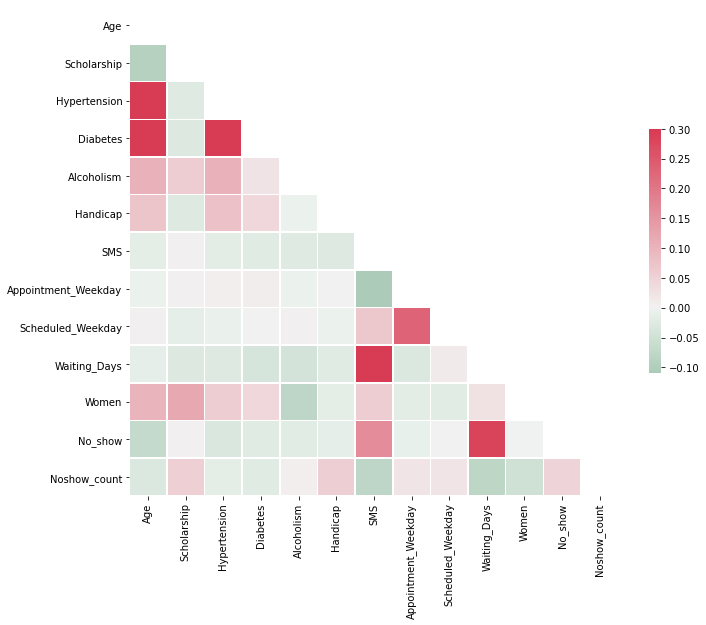

In [637]:
# Compute a correlation matrix, see: http://seaborn.pydata.org/examples/many_pairwise_correlations.html
corr = df1.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(500, 7, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

relevant no-show predictors are: 
- Waiting Days
- SMS reminder
- Noshow_count
- Age
- (Hypertension / Diabetes / Handicap / Alcoholism / Appointment_Weekday)

these variables dont seem to play a big role:
- Gender
- Scholarship
- Scheduled_Weekday

### Q2: Waiting Days and No-Shows

In [664]:
# mean no-show value (is it like probablities/likelihood here?) per number of waiting days 
noshow_means = pd.DataFrame(df.groupby(['Waiting_Days']).No_show.mean().reset_index())
noshow_means.head(3)

,Waiting_Days,No_show
0,0,0.172540
1,1,0.529244
2,2,0.537043


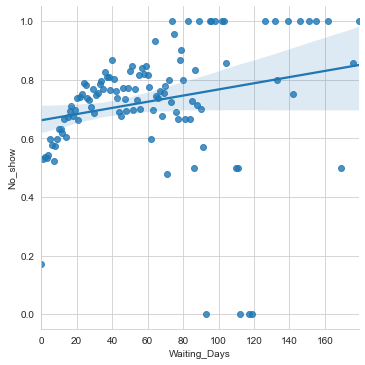

In [681]:
# Scatterplot to visualize the relationship between Waiting Days and No Shows
sns.lmplot(x='Waiting_Days',y='No_show',data=noshow_means,fit_reg=True) 

the more time passes between scheduling an appoointment and the appointment itsself, 
the higher the likelihood of a no-show

In [656]:
# mean number of waiting days for no-shows / show-ups
waiting_means = pd.DataFrame(df.groupby(['No_show']).Waiting_Days.mean().reset_index())
waiting_means

,No_show,Waiting_Days
0,0,7.143409
1,1,15.835484


Text(0, 0.5, 'Mean Waiting Days')

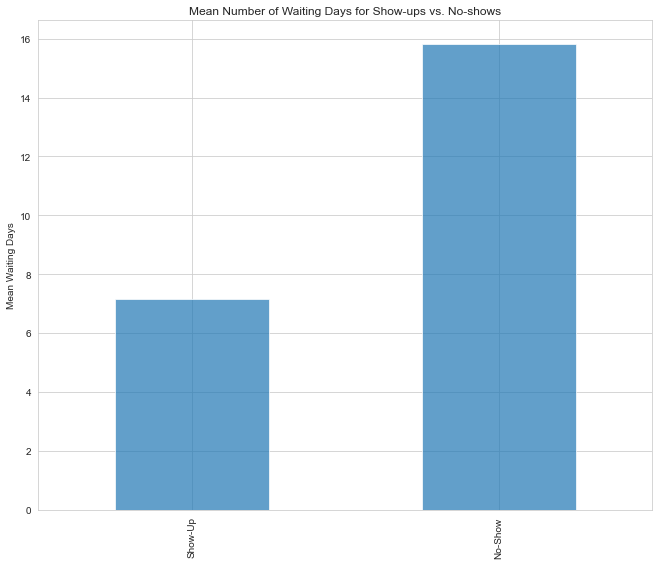

In [695]:
# barchart 
fig = waiting_means['Waiting_Days'].plot(kind='bar', title='Mean Number of Waiting Days for Show-ups vs. No-shows', alpha=.7, figsize=(11, 9))
fig.set_xticklabels(['Show-Up', 'No-Show'])
fig.set_ylabel('Mean Waiting Days')

the average waiting time of show ups lies at around 7 days, the average waiting time of no-shows is more than double at about 16 days -->
it is advisable to plan appointments rather short-term, with no more than a week in advance

In [ ]:
SMS reminder
Noshow_count
Age
(Hypertension / Diabetes / Handicap / Alcoholism / Appointment_Weekday)

In [ ]:
multiple regression


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed in relation to the question(s) provided at the beginning of the analysis. Summarize the results accurately, and point out where additional research can be done or where additional information could be useful.

> **Tip**: Make sure that you are clear with regards to the limitations of your exploration. You should have at least 1 limitation explained clearly. 

> **Tip**: If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])